In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the datasets
consumption_df = pd.read_csv('Datathon Data/Energy Data - Consumption.csv')
emissions_df = pd.read_csv('Datathon Data/Energy Data - Emissions.csv')

# Rename columns to ensure consistency
emissions_df.rename(columns={'MSN': 'EIA_ID'}, inplace=True)
consumption_df.drop(columns=['Energy Category'], inplace=True)

# Remove rows with missing, 'Not Available', or 'Not Meaningful' values in the 'Value' column
consumption_df = consumption_df[~consumption_df['Value'].isna() &
                                (consumption_df['Value'] != 'Not Available') &
                                (consumption_df['Value'] != 'Not Meaningful') &
                                (consumption_df['Value'] != 'No Data Reported')]
emissions_df = emissions_df[~emissions_df['Value'].isna() &
                            (emissions_df['Value'] != 'Not Available') &
                            (emissions_df['Value'] != 'Not Meaningful') &
                            (emissions_df['Value'] != 'No Data Reported')]

# Handle 'N/A', empty, and NaN values in the 'Sector' column to denote 'Overall'
consumption_df['Sector'] = consumption_df['Sector'].replace({'N/A': 'Overall', '': 'Overall', np.nan: 'Overall'})
emissions_df['Sector'] = emissions_df['Sector'].replace({'N/A': 'Overall', '': 'Overall', np.nan: 'Overall'})

# Since the emissions DataFrame was adjusted to match the consumption DataFrame columns
# Ensure the column order in emissions_df matches that of consumption_df before merging
emissions_df = emissions_df[consumption_df.columns]

# reset emissions value to emission
emissions_df.rename(columns={'Value': 'Emission (Mton Co2)'}, inplace=True)
emissions_df.drop(columns=['Unit'], inplace=True)
consumption_df.rename(columns={'Value': 'Consumption'}, inplace=True)
consumption_df['Consumption'] = consumption_df['Consumption'].astype(float)
emissions_df['Emission (Mton Co2)'] = emissions_df['Emission (Mton Co2)'].astype(float)

# change units to match
consumption_df['Consumption'] = consumption_df.apply(lambda row: row['Consumption'] * 178000 if row['Unit'] == 'Billion Cubic Feet' else row['Consumption'], axis=1)
consumption_df['Consumption'] = consumption_df.apply(lambda row: row['Consumption'] / 5 if row['Unit'] == 'Thousand Short Tons' else row['Consumption'], axis=1)
consumption_df.rename(columns={'Consumption': 'Consumption (kBarrel)'}, inplace=True)
consumption_df.drop(columns=['Unit'], inplace=True)

# Merge the datasets. inner join to ensure that only matching rows are retained
final_df = pd.merge(consumption_df, emissions_df, on=['Date', 'YYYYMM', 'Energy Type', 'Energy Class', 'Sector'], how='inner')
final_df.drop(columns=['EIA_ID_y'], inplace=True)
final_df.rename(columns={'EIA_ID_x': 'EIA_ID'}, inplace=True)
final_df.drop(columns=['YYYYMM', 'Description_x', 'Description_y'], inplace=True)
final_df['Emission per Consumption'] = final_df['Emission (Mton Co2)'] / final_df['Consumption (kBarrel)']
final_df['Date'] = pd.to_datetime(final_df['Date'])
final_df.sort_values(by='Date', inplace=True)

# Save the merged dataset
final_df.to_csv('Data/emission_consumption.csv', index=False)

# Display the first few rows of the merged dataset
print(final_df.head())


        EIA_ID       Date  Consumption (kBarrel)  Column_Order_x  \
0      DFRCPUS 1973-01-01           1.706943e+03               1   
15083  PCEIZUS 1973-01-01           6.721000e+00              11   
18749  NGEIPUS 1973-01-01           3.988980e+07              11   
14472  DKEIZUS 1973-01-01           1.808870e+02              10   
13861  PAACPUS 1973-01-01           8.508201e+03               9   

               Energy Type Energy Class          Sector  Emission (Mton Co2)  \
0      Distillate Fuel Oil    Petroleum     Residential               22.796   
15083       Petroleum Coke    Petroleum  Electric Power                0.128   
18749          Natural Gas  Natural Gas  Electric Power               12.163   
14472  Distillate Fuel Oil    Petroleum  Electric Power                2.397   
13861                Total    Petroleum  Transportation              101.775   

       Column_Order_y  Emission per Consumption  
0                   3              1.335487e-02  
15083     

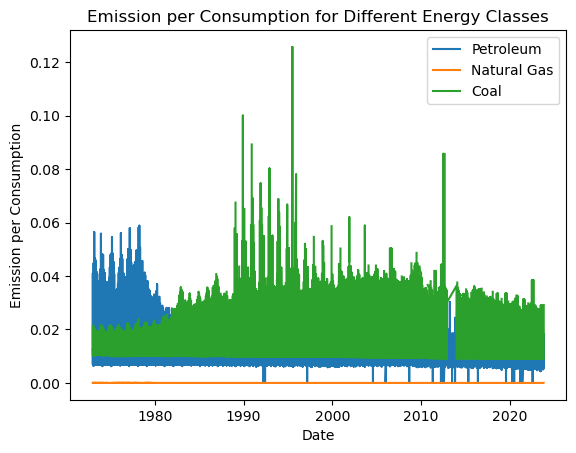

In [42]:
# plot emission per consumption for different energy classes

energy_classes = final_df['Energy Class'].unique()
for energy_class in energy_classes:
    energy_class_df = final_df[final_df['Energy Class'] == energy_class]
    plt.plot(energy_class_df['Date'], energy_class_df['Emission per Consumption'], label=energy_class)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Emission per Consumption')
plt.title('Emission per Consumption for Different Energy Classes')
plt.show()